In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

lm_path = f"../language_modeling.csv"
mcp_path = f"../multiple_choice_prompt.csv"
poe_path = f"./poe.csv" # new path
cha_path = f"../channel.csv"
cal_path = f"../calibration.csv"
lm_df = pd.read_csv(lm_path)
mcp_df = pd.read_csv(mcp_path)
poe_df = pd.read_csv(poe_path)
cha_df = pd.read_csv(cha_path)
cal_df = pd.read_csv(cal_path)
poe_df = poe_df[poe_df["mask_strategy"] == "lowest"] # "below_average" "lowest"


In [10]:
# drop columns should be a list. Use type hints to enforce this.
def process(df, drop_columns=None):
    # get rid of identical rows 
    df = df.drop_duplicates() # is this really necessary?
    # df = df[df["checkpoint"].str.startswith("google/flan-t5")]
    # remove the seed column and batch_size column
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df
    

In [11]:
lm_df = process(lm_df)
mcp_df = process(mcp_df)
poe_df = process(poe_df, drop_columns=["prompting_method", "scoring_method", "mask_accuracy", "mask_strategy", "mask_token"])
cha_df = process(cha_df)
cal_df = process(cal_df)
pre_df = pd.concat([lm_df, mcp_df, poe_df, cha_df, cal_df, ])

In [21]:
df.head(3)

,checkpoint,dataset,method,n_shot,accuracy
6,flan-t5-xl,logical_deduction_five_objects,language_modeling,0,0.47
7,flan-t5-xl,logical_deduction_five_objects,average_language_modeling,0,0.42
22,flan-t5-xl,logical_deduction_five_objects,language_modeling,0,0.51


In [42]:
# datasets="logical_deduction_five_objects conceptual_combinations".split()
datasets = ["logical_deduction_five_objects", "conceptual_combinations"] 
methods = ["multiple_choice_prompt", "process_of_elimination"]
checkpoint="flan-t5-xl"
df = pre_df[pre_df["dataset"].isin(datasets) & pre_df["method"].isin(methods) & pre_df["checkpoint"].str.startswith(checkpoint)]
df = df.groupby(["dataset", "method", "checkpoint", "n_shot"]).mean().reset_index()

# organize by n_shot
df = df.sort_values(by=["dataset", "n_shot"])
# save to csv
# df.to_csv(f"three_shot.csv", index=False)
df

,dataset,method,checkpoint,n_shot,accuracy
0,conceptual_combinations,multiple_choice_prompt,flan-t5-xl,0,0.600
2,conceptual_combinations,process_of_elimination,flan-t5-xl,0,0.760
1,conceptual_combinations,multiple_choice_prompt,flan-t5-xl,3,0.768
3,conceptual_combinations,process_of_elimination,flan-t5-xl,3,0.770
4,logical_deduction_five_objects,multiple_choice_prompt,flan-t5-xl,0,0.398
6,logical_deduction_five_objects,process_of_elimination,flan-t5-xl,0,0.560
5,logical_deduction_five_objects,multiple_choice_prompt,flan-t5-xl,3,0.176
7,logical_deduction_five_objects,process_of_elimination,flan-t5-xl,3,0.192


StopIteration: 

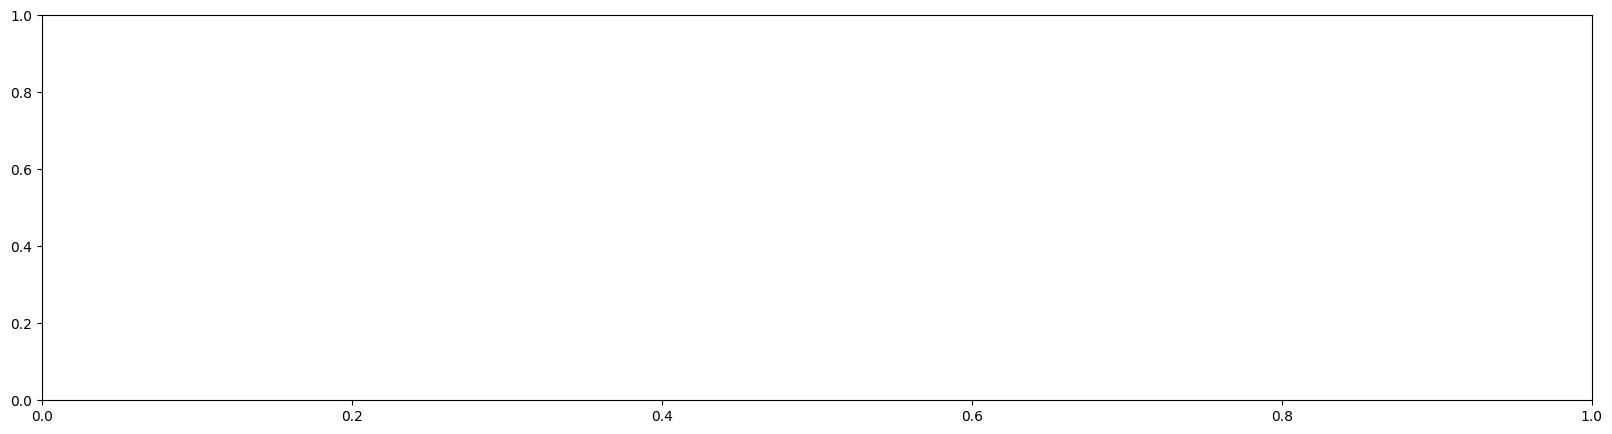

In [6]:
n_shot = 0 # 3.0, 0
df = pre_df[pre_df["n_shot"] == n_shot]

datasets="logical_deduction_five_objects conceptual_combinations".split()
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
method_index += [('accuracy', 'calibration'), ('accuracy', 'channel'), ('accuracy', 'contrastive_decoding')] 

model = "flan-t5-xl"
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim([0.0, 1.0])
h_lines = [0.2, 0.4, 0.6, 0.8]
sing_df = df[(df["dataset"].isin(datasets)) & (df["checkpoint"] == model)]
sing_df.to_csv(f"{n_shot}_shot.csv")
sing_df = sing_df.groupby(["checkpoint", "dataset", "method"])
sing_means = sing_df.mean().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_errors = sing_df.std().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_means.plot.bar(yerr=sing_errors, rot=0, figsize=(20, 5), title=f"{model}: {n_shot} shot", legend=True, ax=ax)
# plot numbers on top of bars
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % float(p.get_height()), ha='center', va='bottom', fontsize=8)
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)

plt.tight_layout()
# plt.savefig(f"{n_shot}_shot.png", dpi=300, bbox_inches='tight')

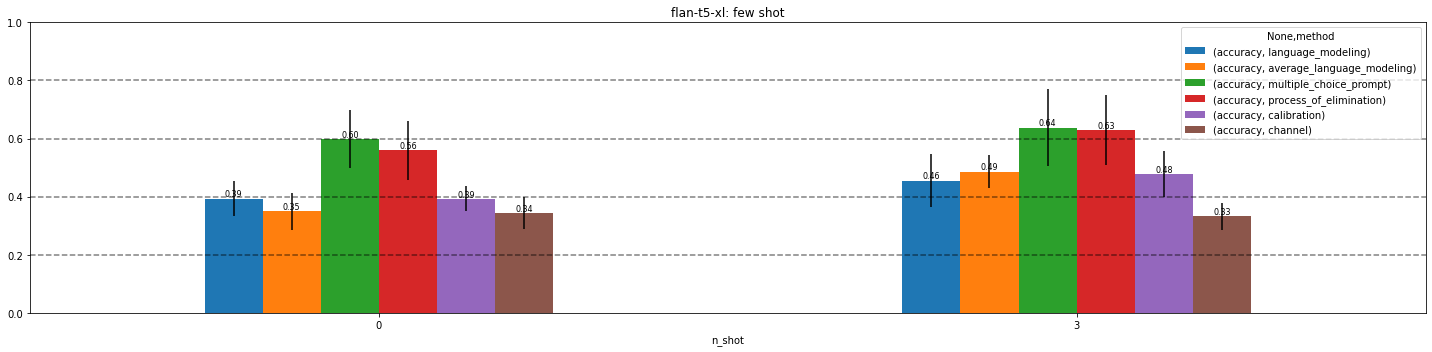

In [5]:
n_shots = [0, 3.0]
df = pre_df[pre_df["n_shot"].isin(n_shots)]

datasets="anli_r1 anli_r2 anli_r3".split()
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
method_index += [('accuracy', 'calibration'), ('accuracy', 'channel')]


model = "flan-t5-xl"
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim([0.0, 1.0])
h_lines = [0.2, 0.4, 0.6, 0.8]
sing_df = df[(df["dataset"].isin(datasets)) & (df["checkpoint"] == model)]
# sing_df.to_csv(f"few_shot.csv")
sing_df = sing_df.groupby(["n_shot", "method"])
sing_means = sing_df.mean().unstack(level=-1).reindex(method_index, axis="columns")
sing_errors = sing_df.std().unstack(level=-1).reindex(method_index, axis="columns")
sing_means.plot.bar(yerr=sing_errors, rot=0, figsize=(20, 5), title=f"{model}: few shot", legend=True, ax=ax)
# plot numbers on top of bars
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % float(p.get_height()), ha='center', va='bottom', fontsize=8)
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)

plt.tight_layout()
# plt.savefig(f"few_shot.png", dpi=300, bbox_inches='tight')

In [6]:
sing_means

accuracy                                                   \
method language_modeling average_language_modeling multiple_choice_prompt   
n_shot                                                                      
0               0.393333                  0.350000               0.599333   
3               0.455333                  0.486667               0.638000   

                                                     
method process_of_elimination calibration   channel  
n_shot                                               
0                    0.560000    0.392667  0.343333  
3                    0.629333    0.478000  0.332667

In [18]:
# to produce latex table.


# post processing in latex: repalce table with table*
# add \hline

# change format, and concatenate two strings.
sing_all = sing_means.applymap(lambda x: f"{x*100:.1f}") + sing_errors.applymap(lambda x: f"\\textsubscript{{{x*100:.1f}}}")
method_index = [('accuracy', 'language_modeling'), 
                ('accuracy', 'average_language_modeling'), 
                ('accuracy', 'calibration'),
                ('accuracy', 'channel'),
                ('accuracy',    'multiple_choice_prompt'), 
                ('accuracy',    'process_of_elimination'),]
sing_all = sing_all.reindex(method_index, axis="columns")


latex_means = sing_all.rename(columns={"language_modeling": "LM",
                                         "average_language_modeling": "AVG",
                                         "multiple_choice_prompt": "MCP",
                                         "process_of_elimination": "PoE",
                                         "calibration": "Calibration",
                                         "channel": "Channel",},
                                         index={0: "0 shot", 3.0: "3 shot"}
                                       )

latex_means.index = latex_means.index.set_names(["n shot"])
latex_means.columns = latex_means.columns.set_names([None, "Method"])

# drop "accuarcy" to save some space
latex_means = latex_means.droplevel(0, axis=1)
# transpose the table
latex_means = latex_means.transpose()

latex_means.style.to_latex(
    buf=f"few_shot.tex",
    column_format="l|c|c",
    position="h",
    position_float="centering",
    label="tab:few_shot",
    caption=r"Few-shot result (accuracy scores) on ANLI. Best scores are \textbf{bold}. PoE applie to both zero-shot and few-shot settings.",
    multicol_align="c",
    multirow_align="c",
)

In [26]:
# sing_means.droplevel(0, axis=1).transpose().max(axis=1)*100
sing_means.droplevel(0, axis=1).transpose().max(axis=0)*100
# find second largest value
sing_means.droplevel(0, axis=1).transpose().apply(lambda x: x.nlargest(2).iloc[-1]*100, axis=0)

n_shot
0    56.000000
3    62.933333
dtype: float64